# __Project 1 - Exercise 1__

In [1]:
using LinearAlgebra, Plots, Statistics, VMLS

In [2]:
# Load dataset
using MAT

vars = matread("spectra.mat");
X = vars["NIR"]; y = vars["octane"];

### __1.1)__

In [3]:
function PLS_nip(X, y; mc = 2)
    # β₀, Β, T, W, P, q = PLS_nip(X,y; mc = 3)
    m, n = size(X)
    mc  = min(mc, min(n,m)-1) # Assure that the number of extracted components is consistent with the size of the problem.
    T   = zeros(m,mc); W   = zeros(n,mc); P   = zeros(n,mc)
    q   = zeros(1,mc);        # - the regression coeffs for the PLS-scores.
    x̄   = mean(X, dims=1)     # - row vector of the X-column mean values.
    ȳ   = mean(y, dims=1)[1]  # - the mean of the response values y.
    y   = y.- ȳ;              # - the centered response vector.
    X   = X.- x̄;              # - the centered X-data
    for a = 1:mc
        w = X'y;  w = w/norm(w);  W[:,a] = w;
        t = X*w;  t = t/norm(t);  T[:,a] = t;
    # ------------------- Deflate X and y ----------------------
        P[:,a] = X't;         X = X - t*P[:,a]';
        q[a]   = (y't)[1];    y = y - q[a].*t;
    end
    # ---------- Calculate regression coefficients -------------
    Β = cumsum((W/triu(P'W)).*q, dims = 2); # the PLS-regression coeffs for the X-data based on up to mc components.
    #Β  = cumsum((W/Bidiagonal(P'W, :U)).*q, dims = 2); # the PLS-regression coeffs for the X-data based on up to mc components.
    β₀ = ȳ .- x̄*Β;            # the correspondning constant terms for the PLS-models.
    return β₀, Β, T, W, P, q;
    end

PLS_nip (generic function with 1 method)

#### __Bidiag2__

In [4]:
function bidiag2(X, y; mc = 2)
    m, n = size(X)
    mc = min(mc, min(n, m) - 1)
    T = zeros(m, mc);    W = zeros(n, mc);    Β = zeros(n, mc)
    P = zeros(n, mc);    q = zeros(1, mc);
    β₀ = zeros(mc);
    B = zeros(mc, 2); # B stored by diagonals (from paper)

    # ------------------- Mean center data ----------------------
    x̄   = mean(X, dims=1)     # - row vector of the X-column mean values.
    ȳ   = mean(y, dims=1)  # - the mean of the response values y.
    y   = y.- ȳ;              # - the centered response vector.
    X   = X.- x̄;              # - the centered X-data

    w = X'y;    w = w / norm(w);    W[:, 1] = w;
    t = X * w;    ρ = norm(t);     t = t / ρ;    T[:, 1] = t;
    B[1, 1] = ρ;    d = w / ρ;    q[1]  = (y't)[1];
    
    Β[:, 1] = (t'y).*d;
    P[:, 1] = X't;
    
    
    for a = 2:mc
        w = X't - ρ * w;    w = w - W * (W' * w);    
        θ = norm(w);    w = w / θ;    W[:, a] = w;
        t = X * w - θ * t; t = t - T * (T't);
        ρ = norm(t);    t = t / ρ;    T[:, a] = t;
        B[a - 1, 2] = θ;    B[a, 1] = ρ;
        P[:, a] = X't;
        q[a]  = (y't)[1];

        d = (w - θ * d) / ρ;
        
        Β[:, a] = Β[:, a - 1] + (t'y).*d;
    end
    β₀ = ȳ .- x̄*Β;
    return β₀, Β, T, W, P, q;
end

bidiag2 (generic function with 1 method)

#### __PLSHY__

In [5]:
function plsHy(X, y; mc = 2)
    # ------------------- Initialize variables ----------------------
    m, n = size(X)
    mc = min(mc, min(n, m) - 1)
    T = zeros(m, mc);    W = zeros(n, mc);    Β = zeros(n, mc)
    P = zeros(n, mc);    q = zeros(1, mc);
    β₀ = zeros(mc);
    B = zeros(mc, 2); # B stored by diagonals (from paper)

    # ------------------- Mean center data ----------------------
    x̄   = mean(X, dims=1)     # - row vector of the X-column mean values.
    ȳ   = mean(y, dims=1)  # - the mean of the response values y.
    y   = y.- ȳ;              # - the centered response vector.
    X   = X.- x̄;              # - the centered X-data

    # ------------------- Calculate first component ----------------------
    w0 = X'y;    w = w0 / norm(w0);
    t = X * w;    ρ = norm(t);    t = t / ρ;    q[1] = (y't)[1]
    W[:, 1] = w;    T[:, 1] = t;    B[1, 1] = ρ;
    d = w / ρ;    Β[:, 1] = (t'y).*d;
    y = y - t * q[1]; # Deflate y
    P[:, 1] = X't;


    # ------------------- Calculate the rest of the components ----------------------
    for a = 2:mc
        w1 = X'y;   w = (w0 - w1)/q[a - 1] - ρ * w;   w0 = w1;
        w = w - W * (W'w);   θ = norm(w);   w = w / θ;
        t = X * w; t = t - T * (T't);
        ρ = norm(t);   t = t / ρ;   q[a] = (y't)[1];
        W[:, a] = w;   T[:, a]= t;
        B[a - 1, 2] = θ;   B[a, 1] = ρ;
        P[:, a] = X't;
    # ------------------- Update regression coefficients -------------------
        d = (w - θ * d) / ρ;
        Β[:, a] = Β[:, a - 1] + q[a].*d;
        y = y - t * q[a];
    end
    β₀ = ȳ .- x̄*Β;
    return β₀, Β, T, W, P, q;
end


plsHy (generic function with 1 method)

### __1.2)__

In [6]:
# PLS_nip algorithm
pc = 10;
β₀_pls, Β_pls, T_pls, W_pls, P_pls, q_pls = PLS_nip(X, y, mc = pc);

In [7]:
# Bidiag2 algorithm
pc = 10;
β₀_bi2, Β_bi2, T_bi2, W_bi2, P_bi2, q_bi2 = bidiag2(X, y, mc = pc);

In [8]:
# PLSHY algorithm
pc = 10;
β₀_hy, Β_hy, T_hy, W_hy, P_hy, q_hy = plsHy(X, y, mc = pc);

In [10]:
using DataFrames

pc = 10
df = DataFrame()
for i in 1:pc
    df[!, Symbol("pc=", i)] = [β₀_pls[i], β₀_bi2[i], β₀_hy[i]]
end

df

Row,pc=1,pc=2,pc=3,pc=4,pc=5,pc=6,pc=7,pc=8,pc=9,pc=10
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,80.2236,90.7017,102.36,99.9158,99.8874,98.5458,90.6389,90.9093,87.7363,85.1143
2,80.2236,90.7017,102.36,99.9158,99.8874,98.5458,90.6389,90.9093,87.7363,85.1143
3,80.2236,90.7017,102.36,99.9158,99.8874,98.5458,90.6389,90.9093,87.7363,85.1143


### __1.3)__

In [12]:
using Random
Random.seed!(5202)
X = rand(300, 1000)
y = rand(300, 1)
samples = 1:300

runtimes = Dict{Symbol, Vector{Float64}}()

for func in [PLS_nip, bidiag2, plsHy]
    runtimes[Symbol(func)] = Float64[]
    prev_runtime = 0.0
    for i = 1:300
        current_runtime = @elapsed func(X[samples .!= i, :], y[samples .!= i, :], mc = 10)
        prev_runtime += current_runtime
        push!(runtimes[Symbol(func)], prev_runtime)
    end
end

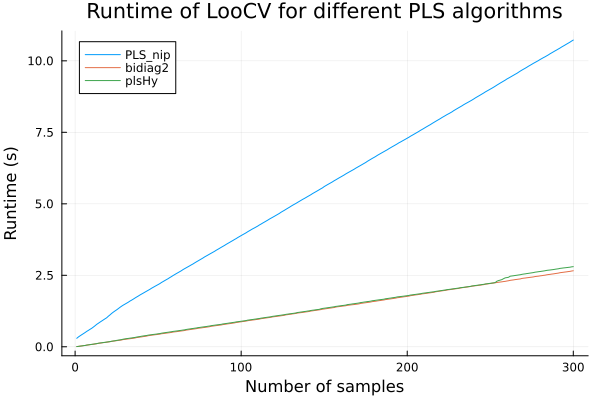

In [13]:
using Plots
p = plot(runtimes[Symbol(PLS_nip)], label="PLS_nip", xlabel="Number of samples", ylabel="Runtime (s)")
plot!(p, runtimes[Symbol(bidiag2)], label="bidiag2")
plot!(p, runtimes[Symbol(plsHy)], label="plsHy")
title!(p, "Runtime of LooCV for different PLS algorithms")

display(p)

In [14]:
using DataFrames

# Total runtime
df = DataFrame(runtimes)
df = last(df, 1)
df

Row,PLS_nip,bidiag2,plsHy
,Float64,Float64,Float64
1,10.7266,2.65894,2.80233


We observe that the *bidiag2* and *plsHy* algorithms perform significantly better than the *NIPALS* algorithm.